# notebook minist and different optimizers

the basis is kaiminig optimization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.modelmanager import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from lib.callbacks import *
from lib.graphics import *
from pathlib import Path

## mnist data

In [4]:
#mnist_path = Path("C:/Users/kl/.fastai/data/mnist.pkl.gz")
mnist_path = Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz")
x_train,y_train,x_valid,y_valid = load_pickled_train_valid_data(mnist_path)
train_mean, train_sd = x_train.mean(), x_train.std()
x_train   = normalize( x_train, train_mean, train_sd)
x_valid   = normalize( x_valid, train_mean, train_sd)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [5]:
nh,bs              = 50,128 #512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=512) )
#                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )
xb, _              = next(iter(train_dl))
print(len(train_dl)), print(len(valid_dl))

391
20


(None, None)

In [6]:
# average loss pr input sample at iteration 0
import numpy as np
nb_classes = 10
initial_loss = -np.log( 1.0/nb_classes ) 
print(f"For equal distribution of cases pr class:\ninitial loss:    {initial_loss}\ninitial accuracy {1.0/nb_classes}")

For equal distribution of cases pr class:
initial loss:    2.3025850929940455
initial accuracy 0.1


In [7]:
mnist_view   = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func    = F.cross_entropy
sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(CudaCallback, device= torch.device('cuda',0)),
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = mnist_view), 
#                partial(MixUp,α=0.4),
#                LR_Finder,
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback
               ]



## resnets + steppers=[sgd_step]

In [ ]:
opt = SGD(sched,max_lr=0.5)#0.5)
#loss_func=LabelSmoothingCrossEntropy()
loss_func=F.cross_entropy

layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=GeneralRelu )
from torch import *
layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )
model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out)()
#model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
mm    = CnnModelManager( model )
mm.initialize(is_resnet=True)


xb,_ = mm.getFirstbatch( data, normalization = mnist_view)
print(f"xb.shape:{xb.shape}")
mm.summary(xb, print_mod=False)
learn = Learner( mm.model, data, loss_func=loss_func)

%time learn.fit(25, opt=opt, cb_funcs=cbfs)

In [ ]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## steppers=[sgd_step]

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)
opt = SGD(sched,max_lr=0.8)#0.5)

#loss_func=LabelSmoothingCrossEntropy()
loss_func=F.cross_entropy
learn = Learner( mm.model, data, loss_func=loss_func)

%time learn.fit(3, opt=opt,cb_funcs=cbfs)

In [ ]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## steppers=[weight_decay, sgd_step]

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt = SGD(sched,max_lr=0.5, max_wd=0.01)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt,cb_funcs=cbfs)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = SGD_Momentum(sched,max_lr=1.0, moms=(0.85,0.95), max_wd=1e-3 )
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

In [ ]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=0),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## Adam: steppers=[adam_step]

In [ ]:
class RReLUOffset(torch.nn.ReLU):
    def __init__(self, post_relu_offset = 0.15, random_range=0.1 ): #0.15915):
        super().__init__(inplace=True)
        self.register_buffer("offset",torch.tensor(post_relu_offset, dtype=torch.float32))
        self.register_buffer("random_range",torch.tensor(random_range, dtype=torch.float32))
        self.register_buffer("central_noise",torch.tensor(post_relu_offset, dtype=torch.float32))
        
    def forward(self, x):
        if self.training:
            if not self.central_noise.size() == x.size():
                self.central_noise = torch.zeros_like(x[0,:], dtype=torch.float32, requires_grad=False)
                nn.init.uniform_(self.central_noise, (self.offset-self.random_range).item(),(self.offset+self.random_range).item()) 
            x = super().forward(x+self.central_noise) - self.central_noise
        else:
            x = super().forward(x+self.offset) - self.offset
        
        return x


activ_func = partial(RReLUOffset,post_relu_offset = 0.15, random_range=0.05)
#activ_func = nn.SELU
#activ_func = nn.CELU
#activ_func = nn.RReLU
#activ_func = partial(nn.PReLU,init=1e-2) 
#activ_func = partial(nn.LeakyReLU,negative_slope=1e-2) 
### activ_func = partial(ReLUOffset) 
#activ_func = partial(nn.ReLU,inplace=True)
model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out, activ_func=activ_func)()
#model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
mm    = CnnModelManager( model )
#mm.initialize(is_resnet=True, a=0, nonlinearity="relu") #leaky_relu
#mm.initialize(is_resnet=True, a=0.015, nonlinearity="leaky_relu")
mm.initialize(is_resnet=True, a=1e-2, nonlinearity="leaky_relu")

#opt   = Adam(sched,max_lr=3e-3, moms=(0.9,0.95), max_wd = 0)#1e-5)#1e-6)
opt   = Adam(sched,max_lr=8e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(50, opt=opt, cb_funcs=cbfs)
#%time learn.fit(150, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.1)])#α=0.025)])
#%time learn.fit(1, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.025),LRFinder])
#%time learn.fit(1, opt=opt, cb_funcs=cbfs.copy()+[LRFinder])


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.281722,0.915840,0.061536,0.981600,01:47
1,0.081367,0.974900,0.050420,0.986300,01:46
2,0.067114,0.980260,0.045710,0.986800,01:46
3,0.055272,0.982880,0.039418,0.988500,01:46
4,0.050671,0.984320,0.033038,0.990100,01:46
5,0.048161,0.984880,0.033384,0.990700,01:46
6,0.042975,0.987140,0.031784,0.989400,01:41
7,0.042503,0.987140,0.028206,0.992200,01:47
8,0.036858,0.988160,0.035145,0.990600,01:48
9,0.038485,0.987760,0.028254,0.991800,01:50


In [24]:
mm.summary(mnist_view(xb))
#print(dict(mm.model.named_buffers()).keys())

<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 1, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 16, 28, 28])
<class '__main__.RReLUOffset'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14])
<class '__main__.RReLUOffset'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14

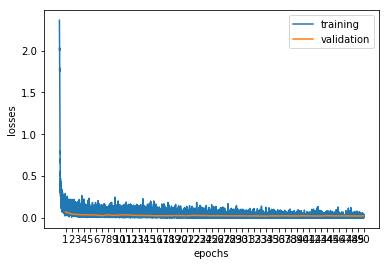

(None, None)

In [66]:
#learn.find_subcription_by_cls(LRFinder).plot_loss(skip_end=8),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
#learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## LAMB: steppers=[lamb_step]

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = LAMB(sched,max_lr=0.02, moms=(0.85,0.95), max_wd = 1e-4)     
#opt   = LAMB(sched,max_lr=0.005, moms=(0.85,0.95), max_wd = 1e-4)     #with mixup
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## mnist with adam and hooks

In [ ]:
#activ_func = partial(nn.ReLU,inplace=True) 
activ_func = partial(ReLUOffset) 
model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out, activ_func=activ_func)()
#model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
mm    = CnnModelManager( model )
mm.initialize(is_resnet=True, a=0.015, nonlinearity="leaky_relu")

#model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out)()
#opt   = Adam(sched,max_lr=0.05, moms=(0.85,0.95), max_wd = 1e-3)
opt     = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 1e-5)#1e-6)# xresnet18
learn   = Learner( mm.model, data, loss_func=F.cross_entropy)
modules = find_submodules(mm.model, lambda m: isinstance(m, (nn.Conv2d,nn.Linear,nn.AvgPool2d,nn.AdaptiveAvgPool2d) ))
#print(modules)
with Hooks(modules, append_stats) as hooks: 
    #learn.fit(3, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.025)])    
    learn.fit(3, opt=opt, cb_funcs=cbfs)    
    plot_layer_stats( hooks )

In [ ]:
mnist_view(xb).shape

In [ ]:
mm.summary(mnist_view(xb))

## mnist with LAMB and hooks

In [ ]:
#model = CnnModelManager( partial(xresnet18, c_in=data.c_in, c_out=data.c_out)() )
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = LAMB(sched,max_lr=0.008, moms=(0.85,0.95), max_wd = 1e-6)     
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
with Hooks(mm.model, append_stats) as hooks: 
    learn.fit(3, opt=opt, cb_funcs=cbfs)
    plot_layer_stats( hooks )